# Setup

In [1]:
%%capture
import scanpy as sc
import scvi
import os
import seaborn as sns
from numpy import var, mean, sqrt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.lines as mlines
import numpy as np
import warnings
from scipy.stats import spearmanr
import scipy
from scipy.stats import ttest_ind

In [2]:
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## file paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Methods

### density of gene expression

In [6]:
def gentoype_gene_expression(
    adata, gene_list, genotype_list, cell_type_key="cell_type",
    cell_type_list=None, genotype_key="genotype", layer="scVI_normalized",
    save_path=None, min_offset=None, *args, **kwargs
):
    gene_list = [i for i in gene_list if i in adata.var_names]
    adata_copy=adata[adata.obs[genotype_key].isin(genotype_list), gene_list]
    tra_expression_data = {}
    for genotype in genotype_list:
        genotype_data = adata_copy[adata_copy.obs[genotype_key] == genotype]
        expression_data = pd.DataFrame(
            genotype_data.layers[layer],
            index=genotype_data.obs.index,
            columns=genotype_data.var_names
        )
        expression_data = np.log1p(expression_data)
        expression_data["cell_type"] = genotype_data.obs[cell_type_key]
        expression_data = expression_data.groupby("cell_type").mean().T
        tra_expression_data[genotype] = expression_data
    for cell_type in cell_type_list:
        plot_data = pd.DataFrame()
        for genotype, tra_expression in tra_expression_data.items():
            plot_data[genotype] = tra_expression[cell_type]
        plot_data = plot_data.melt()
        ax = sns.displot(
            plot_data,
            x="value",
            kind="kde",
            hue="variable",
            *args, **kwargs
        )
        if min_offset is not None:
            plt.xlim(
                min(plot_data.value)-min_offset,
                np.quantile(plot_data.value, 0.99)
            )
        plt.title(cell_type)
        if save_path is not None:
            plt.savefig(save_path, bbox_inches="tight", dpi=300)
        plt.show()
        
def relative_gene_expression(
    adata, gene_lists, cell_type_key="cell_type",
    cell_type_list=None, layer="scVI_normalized",
    save_path=None, xlim=None, *args, **kwargs
):
    lists = {}
    genes = []
    
    for index,gene_list in enumerate(gene_lists):
        gene_list = [i for i in gene_list if i in adata.var_names]
        lists[index] = gene_list
        for i in gene_list:
            genes.append(i)
    genes=list(set(genes))
    adata_copy=adata[:, genes]
                     
    expression_data = pd.DataFrame(
        adata_copy.layers[layer],
        index=adata_copy.obs.index,
        columns=adata_copy.var_names
    )
    expression_data = np.log1p(expression_data)
    expression_data["cell_type"] = adata_copy.obs[cell_type_key]
    expression_data = expression_data.groupby("cell_type").mean().T
    expression_data["gene_list"] = "None"
    
    for key,gene_list in lists.items():
        expression_data.loc[gene_list, "gene_list"] = key
    for cell_type in cell_type_list:
        sns.displot(
            expression_data,
            x=cell_type,
            hue="gene_list",
            kind="kde",
            *args, **kwargs
        )
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    plt.title(cell_type)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

### LFC-LFC plot

In [7]:
def lfc_lfc_plot(
    adata, genotype_list, gene_list_x, gene_list_y, lfc_x, lfc_y, label_genes=None,
    layer="scVI_normalized", color_x="tab:blue", color_y="tab:orange",
    color_both="tab:green", save_path=None
):
    gene_list_both = [i for i in gene_list_x if i in gene_list_y]
    gene_list_x = [i for i in gene_list_x if i not in gene_list_both]
    gene_list_y = [i for i in gene_list_y if i not in gene_list_both]
    
    sns.scatterplot(
        x=lfc_x,
        y=lfc_y,
        s=5,
        linewidth=0,
        c="lightgrey"
    )
    sns.scatterplot(
        x=lfc_x[lfc_x.index.isin(gene_list_x)],
        y=lfc_y[lfc_y.index.isin(gene_list_x)],
        s=5,
        linewidth=0,
        c=color_x
    )
    sns.scatterplot(
        x=lfc_x[lfc_x.index.isin(gene_list_y)],
        y=lfc_y[lfc_y.index.isin(gene_list_y)],
        s=5,
        linewidth=0,
        c=color_y
    )
    sns.scatterplot(
        x=lfc_x[lfc_x.index.isin(gene_list_both)],
        y=lfc_y[lfc_y.index.isin(gene_list_both)],
        s=5,
        linewidth=0,
        c=color_both
    )
    if label_genes is not None:
        for gene in label_genes:
            plt.text(
                lfc_x[lfc_x.index == gene],
                lfc_y[lfc_y.index == gene],
                s=gene,
                color="tab:blue",
                fontdict={"fontsize":12},
            )
    plt.axvline(x=-1, linestyle="dashed", color="black")
    plt.axvline(x=1, linestyle="dashed", color="black")
    plt.axhline(y=-1, linestyle="dashed", color="black")
    plt.axhline(y=1, linestyle="dashed", color="black")
    plt.xlabel(f"LFC {genotype_list[0]}/{genotype_list[1]}")
    plt.ylabel(f"LFC {genotype_list[0]}/{genotype_list[2]}")
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

## import data

In [8]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
tabulaMurisData = sc.read(f"{processedDataPath}/M_cell/h5ad_files/tabula_muris_expression_filtered_genes.h5ad")
pbmc = sc.read(f"{processedDataPath}/M_cell/h5ad_files/PBMC_all_genes.h5ad")

# Shared AireKO/Fezf2 DE genes

In [9]:
fezf2DE = pd.read_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters.csv", index_col=0)
aireDE = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters.csv",index_col=0)
fezf2DE_filtered = pd.read_csv("../../analysis/Fezf2_WT_vs_KO_DE/all_clusters_filtered.csv", index_col=0)
aireDE_filtered = pd.read_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters_filtered.csv",index_col=0)

In [10]:
both = fezf2DE_filtered[fezf2DE_filtered.index.isin(aireDE_filtered.index)]
both["lfc_mean_Aire"] = aireDE_filtered[aireDE_filtered.index.isin(both.index)].lfc_mean

/tmp/ipykernel_826408/3819602205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both["lfc_mean_Aire"] = aireDE_filtered[aireDE_filtered.index.isin(both.index)].lfc_mean


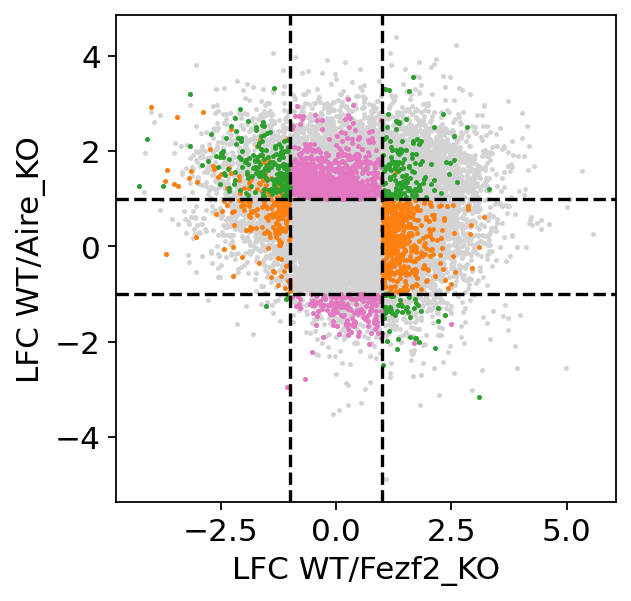

In [11]:
lfc_lfc_plot(
    adata,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    lfc_x=fezf2DE.lfc_mean,
    lfc_y=aireDE.lfc_mean,
    gene_list_x=fezf2DE_filtered.index,
    gene_list_y=aireDE_filtered.index,
    color_x="tab:orange",
    color_y="tab:pink",
    save_path="../../analysis/Paper figs/2 (Aire KO)/2L_overlapping_de_genes.pdf"
)

# Post Aire genes

In [12]:
geneList = ["Ccl20" , "Klk1", "Apoa4", "Avil", "Ivl", "Spib", "Tspan8", "Ascl1", "Gp2", "Foxj1", "Ccl20", "Pou2f3", 
            "Dclk1", "Trpm5", "Sox8", "Mcidas", "Grhl1", "Foxj1", "Foxa2", "Hnf4a", "Snai2", "Chat", "Ccl9", "Tnfaip2",
            "Guca2a", "Dynlrb2", "Dnah12", "Actc1", "Ckm", "Cftr", "Atp6v1g3", "Prss2", "Clps", "Chgb", "Ret", "Aqp4", "Muc5b",
           "Spink5", "Rptn", "Krt10", "Krtdap", "Sbsn", "Tnfrsf11b", "Msln", "Ccl6", "Reg3g", "Muc13", "Ces2e", "Pigr", "Saa1", "Saa3",
           "Cacna2d1", "Snap25", "Scg5", "Stxbp5l", "Cfap44", "Dnah12", "Ccdc153", "Dynlrb2", "Slc12a2", "Foxi1", "Atp6v1g3", "Foxi2",
            "Atp6v0d2", "Atp6v1b1", "Asprv1", "Dmkn", "Sbsn", "Calm4", "Cnfn", "Il1f5", "Flg", "Rgs13", "Hck", "Alox5ap", "Plcb2", "Myog",
           "Meg3", "Actc1", "Mymx", "Myl1", "Acta1", "Mylpf"]
geneList = set(geneList)
both = []
aireReg = []
fezf2Reg = []
neither = []
missed_aire_reg = []
missed_fezf2_reg = []
missed_both_reg = []
for gene in geneList:
    if gene not in adata.var_names:
        print(f"Error: {gene} not in data")
    if gene in fezf2DE_filtered.index:
        if gene in aireDE_filtered.index:
            both.append(gene)
        else:
            fezf2Reg.append(gene)
    else:
        if gene in aireDE_filtered.index:
            aireReg.append(gene)
        else:
            neither.append(gene)
print(f"Aire-regulated: {aireReg}, \nFezf2-regulated: {fezf2Reg}, \nboth: {both}")
print()

high_lfc = []
for gene in neither:
    if fezf2DE[fezf2DE.index == gene].lfc_mean.values > 1:
        if aireDE[aireDE.index == gene].lfc_mean.values > 1:
            missed_both_reg.append(gene)
        else:
            missed_fezf2_reg.append(gene)
        neither.remove(gene)
    else:
        if aireDE[aireDE.index == gene].lfc_mean.values > 1:
            missed_aire_reg.append(gene)
            neither.remove(gene)
missed = missed_fezf2_reg + missed_aire_reg + missed_both_reg
print(f"Missed Fezf2-reg: {missed_fezf2_reg}, \nMissed Aire-reg: {missed_aire_reg}, \nMissed both: {missed_both_reg}")
print()
print(f"neither: {neither}")

Aire-regulated: ['Aqp4', 'Spink5', 'Slc12a2', 'Dmkn', 'Krtdap', 'Dclk1', 'Krt10', 'Calm4', 'Muc13', 'Hck', 'Clps', 'Cftr', 'Cacna2d1', 'Gp2', 'Sbsn'], 
Fezf2-regulated: ['Tnfaip2', 'Chat', 'Rgs13', 'Msln', 'Snap25', 'Ces2e', 'Rptn', 'Asprv1', 'Alox5ap', 'Foxa2', 'Reg3g'], 
both: ['Saa1', 'Saa3', 'Cnfn', 'Apoa4', 'Ccl20', 'Flg', 'Il1f5', 'Klk1', 'Pigr', 'Plcb2', 'Avil']

Missed Fezf2-reg: ['Mymx', 'Meg3'], 
Missed Aire-reg: ['Myl1', 'Cfap44', 'Muc5b'], 
Missed both: ['Guca2a', 'Prss2', 'Ivl', 'Atp6v0d2', 'Actc1', 'Foxi1', 'Atp6v1b1', 'Chgb', 'Acta1']

neither: ['Ccl6', 'Ccdc153', 'Tspan8', 'Mcidas', 'Dynlrb2', 'Mylpf', 'Tnfrsf11b', 'Ascl1', 'Dnah12', 'Foxj1', 'Sox8', 'Spib', 'Foxi2', 'Ccl9', 'Stxbp5l', 'Hnf4a', 'Scg5', 'Trpm5', 'Ckm', 'Ret', 'Grhl1', 'Myog', 'Snai2', 'Pou2f3', 'Atp6v1g3']


In [13]:
postAireRegulatedGenes = pd.DataFrame([aireReg, fezf2Reg, both, neither, missed], index=["Aire-regulated", "Fezf2-regulated", "both", "neither", "Failed expression cutoffs"]).T
postAireRegulatedGenes.to_csv("../../analysis/post_aire_highly_de_gene_lists.csv", index=False)

# Fezf2 vs Aire induced gene expression

In [14]:
fezf2_induced = [i for i in fezf2DE_filtered[fezf2DE_filtered.lfc_mean > 0].index if i not in aireDE_filtered[aireDE_filtered.lfc_mean > 0].index]
aire_induced = [i for i in aireDE_filtered[aireDE_filtered.lfc_mean > 0].index if i not in fezf2DE_filtered[fezf2DE_filtered.lfc_mean > 0].index]
both = [i for i in aireDE_filtered[aireDE_filtered.lfc_mean > 0].index if i in fezf2DE_filtered[fezf2DE_filtered.lfc_mean > 0].index]

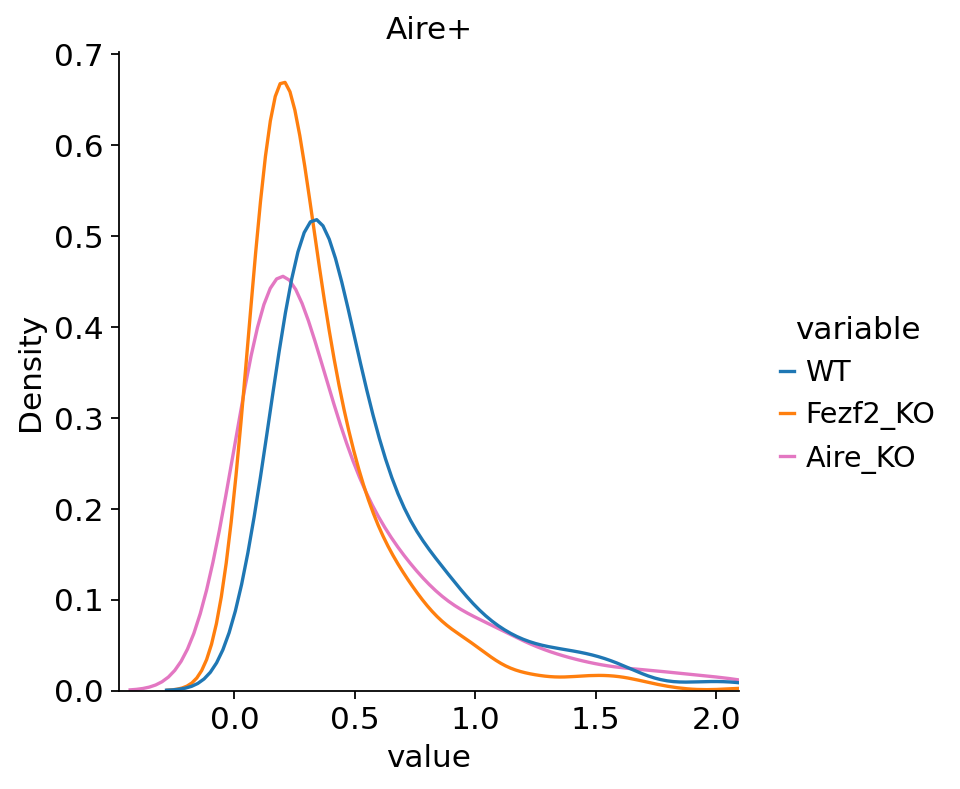

In [15]:
gentoype_gene_expression(
    adata,
    gene_list=fezf2_induced,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_key="cell_type",
    cell_type_list=["Aire+"],
    genotype_key="genotype",
    layer="scVI_normalized",
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3G_fezf2_induced_gene_expression_across_genotypes.pdf",
    min_offset=0.5,
    palette=["tab:blue", "tab:orange", "tab:pink"],
)

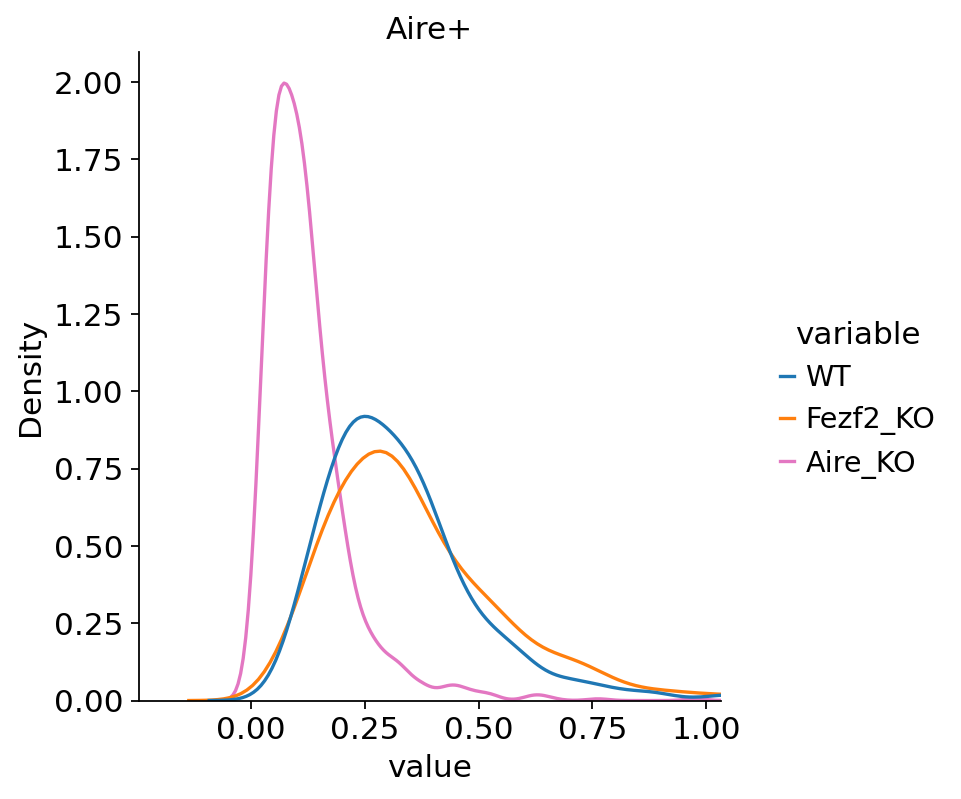

In [16]:
gentoype_gene_expression(
    adata,
    gene_list=aire_induced,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["Aire+"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3G_aire_induced_gene_expression_across_genotypes.pdf",
    min_offset=0.25,
    palette=["tab:blue", "tab:orange", "tab:pink"],
)

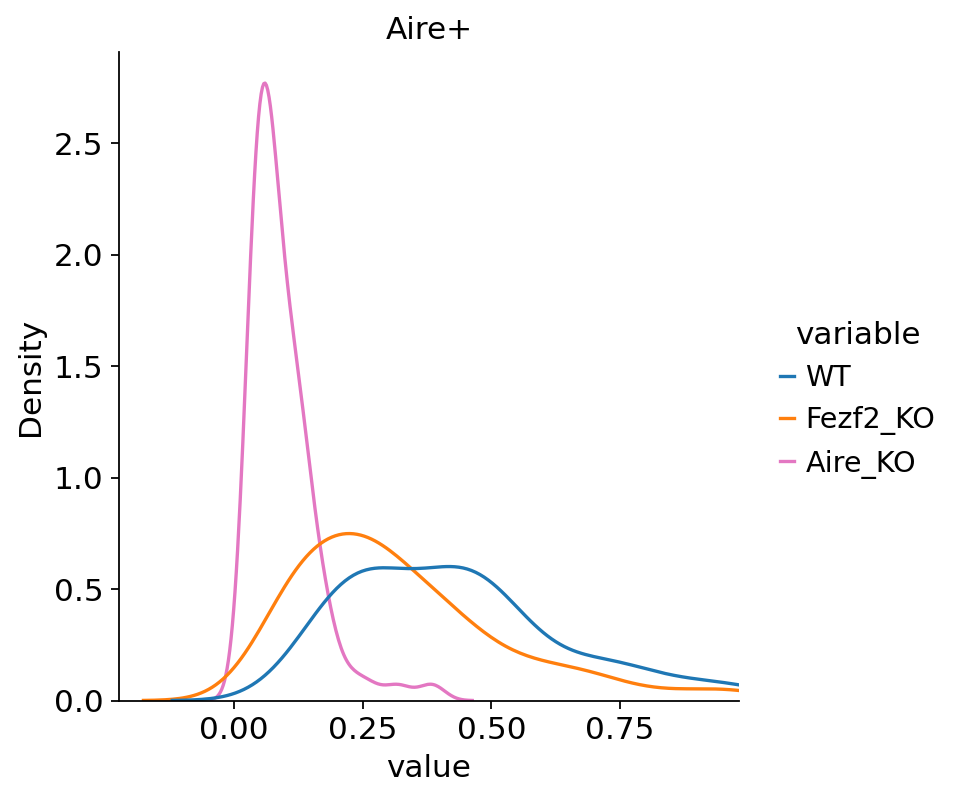

In [17]:
gentoype_gene_expression(
    adata,
    gene_list=both,
    genotype_list=["WT", "Fezf2_KO", "Aire_KO"],
    cell_type_list=["Aire+"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3G_both_induced_gene_expression_across_genotypes.pdf",
    min_offset=0.25,
    palette=["tab:blue", "tab:orange", "tab:pink"],
)

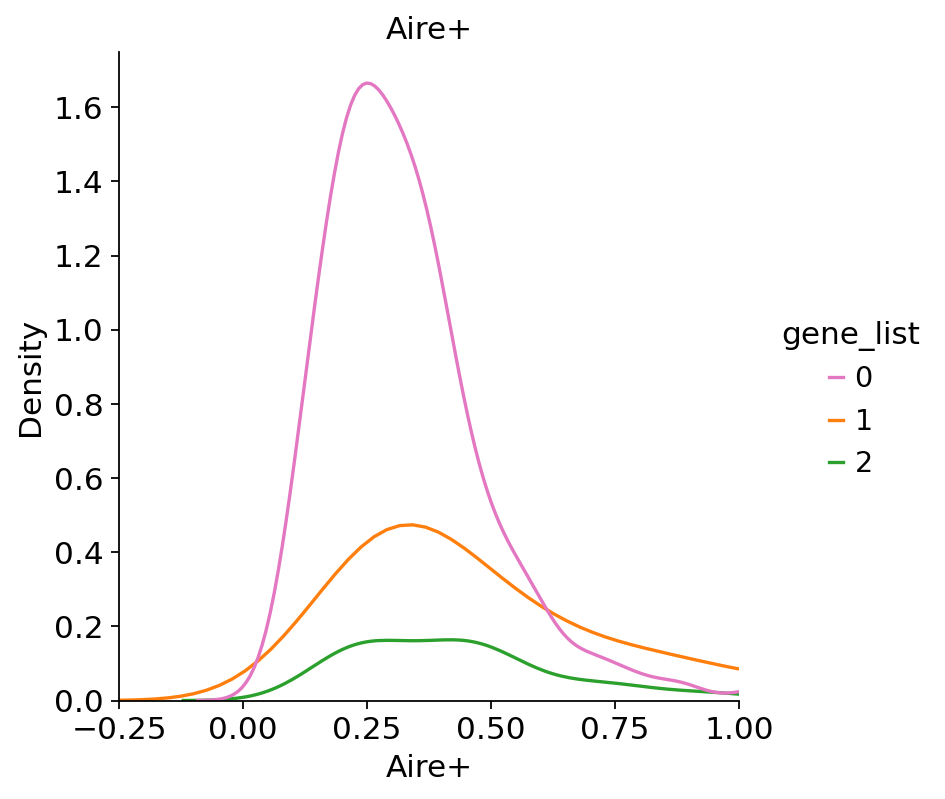

In [18]:
relative_gene_expression(
    adata[adata.obs.genotype == "WT"],
    gene_lists = [aire_induced, fezf2_induced, both],
    cell_type_list=["Aire+"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3F_relative_induced_gene_expression.pdf",
    xlim=[-0.25, 1],
    palette=["tab:pink", "tab:orange", "tab:green"]
)